[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/OP_2025/blob/main/analysis_scripts/Linear_Regression_OMIC.ipynb)

# Clone github repo

In [ ]:
!git clone https://github.com/pachterlab/OP_2025.git
%cd /content/OP_2025/

# Download Data

In [ ]:
!mkdir omics_adata
!wget -O omics_adata/rat_RNA_meta.h5ad https://data.caltech.edu/records/j57wp-0pp06/files/rat_RNA_meta.h5ad?download=1
!wget -O omics_adata/rat_ACETYL_meta.h5ad https://data.caltech.edu/records/j57wp-0pp06/files/rat_ACETYL_meta.h5ad?download=1
!wget -O omics_adata/rat_ATAC_meta.h5ad https://data.caltech.edu/records/j57wp-0pp06/files/rat_ATAC_meta.h5ad?download=1
!wget -O omics_adata/rat_IMMUNO_meta.h5ad https://data.caltech.edu/records/j57wp-0pp06/files/rat_IMMUNO_meta.h5ad?download=1
!wget -O omics_adata/rat_METAB_meta.h5ad https://data.caltech.edu/records/j57wp-0pp06/files/rat_METAB_meta.h5ad?download=1
!wget -O omics_adata/rat_METHYL_meta.h5ad https://data.caltech.edu/records/j57wp-0pp06/files/rat_METHYL_meta.h5ad?download=1
!wget -O omics_adata/rat_PHOSPHO_meta.h5ad https://data.caltech.edu/records/j57wp-0pp06/files/rat_PHOSPHO_meta.h5ad?download=1
!wget -O omics_adata/rat_PROT_meta.h5ad https://data.caltech.edu/records/j57wp-0pp06/files/rat_PROT_meta.h5ad?download=1
!wget -O omics_adata/rat_UBIQ_meta.h5ad https://data.caltech.edu/records/j57wp-0pp06/files/rat_UBIQ_meta.h5ad?download=1


# Install Packages

In [ ]:
!pip install -qr requirements.txt 

In [ ]:
import os, sys
sys.path.append('analysis_scripts')
import anndata
import numpy as np
import pandas as pd
import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import sklearn.linear_model 
from sklearn import metrics
from sklearn.metrics import mean_squared_error

from rat_friend import *

In [3]:
color_dict = {'male': '#E07F80',
            'female': '#317EC2',
              'M': '#E07F80',
            'F': '#317EC2'
}

color_opts =  np.array([
    "#D55E00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#E69F00", "#CC79A7", "#666666", "#AD7700", "#1C91D4", "#007756", "#D5C711", "#005685",
    "#A04700", "#B14380", "#4D4D4D", "#FFBE2D", "#80C7EF", "#00F6B3", "#F4EB71", "#06A5FF", "#FF8320", "#D99BBD", "#8C8C8C", "#FFCB57", "#9AD2F2",
    "#2CFFC6", "#F6EF8E", "#38B7FF", "#FF9B4D", "#E0AFCA", "#A3A3A3", "#8A5F00", "#1674A9", "#005F45", "#AA9F0D", "#00446B", "#803800", "#8D3666",
    "#3D3D3D"
])
tissues = ['ADRNL','BAT','BLOOD','COLON','CORTEX','HEART','HIPPOC','HYPOTH',
 'KIDNEY','LIVER', 'LUNG','OVARY','SKM-GN','SKM-VL','SMLINT','SPLEEN','TESTES','VENACV','WAT']
for x in range(len(tissues)):
    color_dict[tissues[x]] = color_opts[x]

color_dict

{'male': '#E07F80',
 'female': '#317EC2',
 'M': '#E07F80',
 'F': '#317EC2',
 'ADRNL': '#D55E00',
 'BAT': '#56B4E9',
 'BLOOD': '#009E73',
 'COLON': '#F0E442',
 'CORTEX': '#0072B2',
 'HEART': '#E69F00',
 'HIPPOC': '#CC79A7',
 'HYPOTH': '#666666',
 'KIDNEY': '#AD7700',
 'LIVER': '#1C91D4',
 'LUNG': '#007756',
 'OVARY': '#D5C711',
 'SKM-GN': '#005685',
 'SKM-VL': '#A04700',
 'SMLINT': '#B14380',
 'SPLEEN': '#4D4D4D',
 'TESTES': '#FFBE2D',
 'VENACV': '#80C7EF',
 'WAT': '#00F6B3'}

# Linear Regression of all -Omics at Once

## Initial Data Loading

Tissues subset to Heart due to it being shared across all omics and higher predictive power than Liver in RNA alone

In [4]:
tiss = 'HEART'

og_adata = anndata.read_h5ad("omics_adata/rat_RNA_meta.h5ad")
og_adata.obs.time = og_adata.obs.time.astype('int')
sc.pp.normalize_total(og_adata)
og_adata.layers["counts"] = og_adata.X.copy()
rna_adata = og_adata[og_adata.obs.tissue == tiss]
rna_adata.var['omic'] = 'RNA'
rna_adata

/tmp/ipykernel_1990729/3153960449.py:8: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  rna_adata.var['omic'] = 'RNA'


AnnData object with n_obs × n_vars = 49 × 24770
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'outlier', 'original_out', 'old_tissue'
    var: 'gene_id', 'has_U_tr', 'eff_len', 'mt', 'ensembl_transcript_id', 'description', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8', 'omic'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

In [ ]:
big_adata = rna_adata.copy()
big_adata.obs.index = big_adata.obs.nid.astype('str')
var_omic_list = list(big_adata.var.omic)
# omics data was generated using normalized counts from original paper, so only processing is filtering 
for omic in ['ATAC', 'METHYL', 'ACETYL', 'PROT', 'PHOSPHO', 'UBIQ', 'METAB', 'IMMUNO']:
    print(omic)
    adata = load_annotated_omic(f'omics_adata/rat_{omic}_meta.h5ad', omic)
    adata.obs.index = adata.obs.nid
    adata = adata[adata.obs.tissue == tiss]
    adata.var['omic'] = omic
    print(adata.X.shape)
    all_present = list(set(adata.obs.index) & set(big_adata.obs.index))
    big_adata = big_adata[big_adata.obs.index.isin(all_present)].copy()
    adata = adata[adata.obs.index.isin(all_present)].copy()
    
    big_adata = anndata.concat([big_adata, adata], axis = 1, join = 'outer')
big_adata

ATAC


/tmp/ipykernel_1990729/2010948738.py:10: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['omic'] = omic


(50, 1213087)
METHYL


/tmp/ipykernel_1990729/2010948738.py:10: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['omic'] = omic


(50, 1023169)


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_1990729/2010948738.py:10: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['omic'] = omic


ACETYL
(54, 2724)


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_1990729/2010948738.py:10: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['omic'] = omic


PROT
(60, 3917)


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


PHOSPHO
(60, 2459)


/tmp/ipykernel_1990729/2010948738.py:10: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['omic'] = omic
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_1990729/2010948738.py:10: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['omic'] = omic


UBIQ
(59, 2256)


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


METAB
(54, 3043)


/tmp/ipykernel_1990729/2010948738.py:10: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['omic'] = omic
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


IMMUNO
(48, 60)


/tmp/ipykernel_1990729/2010948738.py:10: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['omic'] = omic
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 35 × 2275485
    var: 'gene_id', 'has_U_tr', 'eff_len', 'mt', 'ensembl_transcript_id', 'description', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8', 'omic', 'assay', 'assay_code', 'feature_ID', 'chrom', 'start', 'end', 'width', 'chipseeker_annotation', 'custom_annotation', 'distanceToTSS', 'relationship_to_gene', 'ensembl_gene', 'geneStart', 'geneEnd', 'geneLength', 'geneStrand', 'Chr', 'Locus', 'EntrezID', 'Symbol', 'Strand', 'Width', 'NumSites', 'Sites', 'LocStart', 'LocEnd', 'entrez_gene', 'rgd_gene', 'gene_symbol', 'old_gene_symbol', 'X', 'kegg_id', 'dataset'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

In [ ]:
# ensure all metadata is added
phenotype = rna_adata.obs
slim_pheno = phenotype.loc[:,[('calculated' in x) or (x in ['nid', 'group', 'sex']) for x in phenotype.columns.values]]
time_course = {'control':0, '1w': 1, '2w': 2, '4w': 4, '8w': 8}
slim_pheno = slim_pheno.groupby("nid").agg('first')
slim_pheno['time'] =  [time_course[x] for x in slim_pheno['group']]
slim_pheno = slim_pheno.reset_index()
big_adata.obs = big_adata.obs.reset_index()
big_adata.obs = pd.merge(big_adata.obs.reset_index(drop=True), slim_pheno, on='nid', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
big_adata.X = np.nan_to_num(big_adata.X, nan=0)
big_adata.layers['counts'] = big_adata.X
big_adata = big_adata[:,np.sum(big_adata.X, axis=0) > 0]
big_adata

/tmp/ipykernel_1990729/3047893125.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  slim_pheno = slim_pheno.groupby("nid").agg('first')


View of AnnData object with n_obs × n_vars = 35 × 1648527
    obs: 'nid', 'sex', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'group', 'time'
    var: 'gene_id', 'has_U_tr', 'eff_len', 'mt', 'ensembl_transcript_id', 'description', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8', 'omic', 'assay', 'assay_code', 'feature_ID', 'chrom', 'start', 'end', 'width', 'chipseeker_annotation', 'custom_annotation', 'distanceToTSS', 'relationship_to_gene', 'ensembl_gene', 'geneStart', 'geneEnd', 'geneLength', 'geneStrand', 'Chr', 'Locus', 'EntrezID', 'Symbol', 'Strand', 'Width', 'NumSites', 'Sites', 'LocStart', 'LocEnd', 'entrez_gene', 'rgd_gene', 'gene_symbol', 'old_gene_symbol', 'X', 'kegg_id

## Run Ridge Regression

Subset to females only due to missing too many male timepoints

In [7]:
big_adata = big_adata[big_adata.obs.sex == 'female']

X = big_adata.X
y = big_adata.obs
z = big_adata.var

In [ ]:
np.random.seed(0)

train_filter = y.reset_index(drop=True)[['nid', 'time', 'sex']].groupby('nid',observed=False).agg(lambda x: x.value_counts().index[0])
train_nids = train_filter.groupby(['time', 'sex'],observed=False).apply(lambda x: x.sample(1+np.round(len(x)/3).astype('int')),include_groups=False).index.get_level_values(2).tolist()
ref_mask = [x in train_nids for x in y.nid]


X_train = X[ref_mask]
X_test = X[list(~np.array(ref_mask))]
y_train = y[ref_mask]
y_test = y[list(~np.array(ref_mask))]

# instantiate the model (using the default parameters)
model = sklearn.linear_model.Ridge(random_state=0)

# fit the model with data
model.fit(X_train, y_train.time)

y_pred = model.predict(X_test)
big_ccc = get_CCC(y_test.time.astype('int'), y_pred)
big_r2 = sklearn.metrics.r2_score(y_test.time.astype('int'), y_pred)

In [9]:
y[['nid', 'time', 'sex']].groupby(['time', 'sex'],observed=False).count()

,,nid
time,sex,
0,female,5
1,female,4
2,female,5
4,female,4
8,female,5


In [10]:
result_df = pd.DataFrame({'Predicted Weeks of Exercise':[],
                       'Weeks of Exercise':[],
                       'Omic':[],
                          'sex':[],
                       'ccc':[]
                       })

test_df = pd.DataFrame({'Predicted Weeks of Exercise' : y_pred,
                            'Weeks of Exercise' : y_test.time,
                            'sex': y_test.sex
                             })
test_df.index = y_test.nid
test_df['Subset'] = 'test'
train_df = pd.DataFrame({'Predicted Weeks of Exercise' : model.predict(X_train),
                            'Weeks of Exercise' : y_train.time,
                            'sex': y_train.sex
                             })
train_df.index = y_train.nid
train_df['Subset'] = 'train'
temp_df = pd.concat([test_df, train_df])
temp_df['ccc'] = big_ccc
temp_df['Omic'] = 'All -Omics'


result_df = pd.concat([result_df, temp_df])
result_df.head()

/tmp/ipykernel_1990729/981852937.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, temp_df])


,Predicted Weeks of Exercise,Weeks of Exercise,Omic,sex,ccc,Subset
F0K,2.559581,0.0,All -Omics,female,0.659406,test
F0L,2.133783,0.0,All -Omics,female,0.659406,test
F1F,1.105268,1.0,All -Omics,female,0.659406,test
F1N,-0.941066,1.0,All -Omics,female,0.659406,test
F2C,0.873002,2.0,All -Omics,female,0.659406,test


# Linear Regression of each OMIC individually

In [11]:
# omics data was generated using normalized counts from original paper, so only processing is filtering 
# 
for omic in ['ATAC', 'METHYL', 'ACETYL', 'PROT', 'PHOSPHO', 'UBIQ', 'METAB', 'IMMUNO']:
    print(omic)
    adata = load_annotated_omic(f'omics_adata/rat_{omic}_meta.h5ad', omic)
    adata.obs.time = adata.obs.time.astype('int')
    
    if omic in ['RNA']:
        sc.pp.normalize_total(adata)
        adata.layers['counts'] = adata.X
        
    X, y, z = data_reshaper_omic(adata, tiss_list = adata.obs.tissue.unique(),omic=omic)
    y = y.reset_index(drop=True)
    
    np.random.seed(0)
    train_filter = y.reset_index(drop=True)[['nid', 'time', 'sex']].groupby('nid',observed=False).agg(lambda x: x.value_counts().index[0])
    train_nids = train_filter.groupby(['time', 'sex'],observed=False).apply(lambda x: x.sample(1+np.round(len(x)/3).astype('int')),include_groups=False).index.get_level_values(2).tolist()
    ref_mask = [x in train_nids for x in y.nid]
    
    
    X_train = X[ref_mask]
    X_test = X[list(~np.array(ref_mask))]
    y_train = y[ref_mask]
    y_test = y[list(~np.array(ref_mask))]
    
    # instantiate the model (using the default parameters)
    model = sklearn.linear_model.Ridge(random_state=0)
    
    # fit the model with data
    model.fit(X_train, y_train.time)
    
    y_pred = model.predict(X_test)
    tiss_ccc = get_CCC(y_test.time.astype('int'), y_pred)
    tiss_r2 = sklearn.metrics.r2_score(y_test.time.astype('int'), y_pred)
    
    test_df = pd.DataFrame({'Predicted Weeks of Exercise' : y_pred,
                        'Weeks of Exercise' : y_test.time,
                        'sex': y_test.sex,
                         })
    test_df.index = y_test.nid
    test_df['Subset'] = 'test'
    train_df = pd.DataFrame({'Predicted Weeks of Exercise' : model.predict(X_train),
                                'Weeks of Exercise' : y_train.time,
                                'sex': y_train.sex,
                                 })
    train_df.index = y_train.nid
    train_df['Subset'] = 'train'
    temp_df = pd.concat([test_df, train_df])
    temp_df['ccc'] = tiss_ccc
    temp_df['Omic'] = omic
    
    print(tiss_ccc, tiss_r2)
    result_df = pd.concat([result_df, temp_df])

ATAC


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


BAT
HEART
HIPPOC
KIDNEY
LIVER
LUNG
SKM-GN
WAT


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:750: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['M0A', 'M8A', 'M8B', 'M8C', 'M8E']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


-0.0797520026546359 -0.8255668545564308
METHYL


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


BAT
HEART
HIPPOC
KIDNEY
LIVER
LUNG
SKM-GN
WAT


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:750: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['M0A', 'M8A', 'M8B', 'M8C', 'M8E']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.018500115294185104 0.017891098613796563
ACETYL
HEART
LIVER


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.7275971922955602 0.6481472793575143
PROT
CORTEX
SKM-GN


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


HEART
KIDNEY
LIVER
LUNG
WAT


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.7586983793053496 0.6887909631559271
PHOSPHO
CORTEX
SKM-GN
HEART
KIDNEY
LIVER
LUNG
WAT


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.5779540004147953 0.4901774087595122
UBIQ
HEART
LIVER


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.31263198246899343 0.20562602801803553
METAB
SKM-GN
HEART


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


KIDNEY
LIVER
LUNG
BAT
WAT
HIPPOC
PLASMA
ADRNL
COLON
CORTEX
HYPOTH
SMLINT
SPLEEN
SKM-VL


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0.624278928059732 0.46647678768145195
IMMUNO
PLASMA
SKM-GN
BAT
WAT
HIPPOC
CORTEX
SKM-VL


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


HEART
KIDNEY
ADRNL
COLON
SPLEEN
LUNG
SMLINT
LIVER
0.16126474444588734 -0.9758987778708945


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
result_df.head()

,Predicted Weeks of Exercise,Weeks of Exercise,Omic,sex,ccc,Subset
F0K,2.559581,0.0,All -Omics,female,0.659406,test
F0L,2.133783,0.0,All -Omics,female,0.659406,test
F1F,1.105268,1.0,All -Omics,female,0.659406,test
F1N,-0.941066,1.0,All -Omics,female,0.659406,test
F2C,0.873002,2.0,All -Omics,female,0.659406,test


/tmp/ipykernel_1990729/1390687877.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(6, 8, f'ccc = {round(result_df[result_df.Omic == list(g.axes_dict.keys())[key_num]].ccc[0], 3)}', c = 'grey')


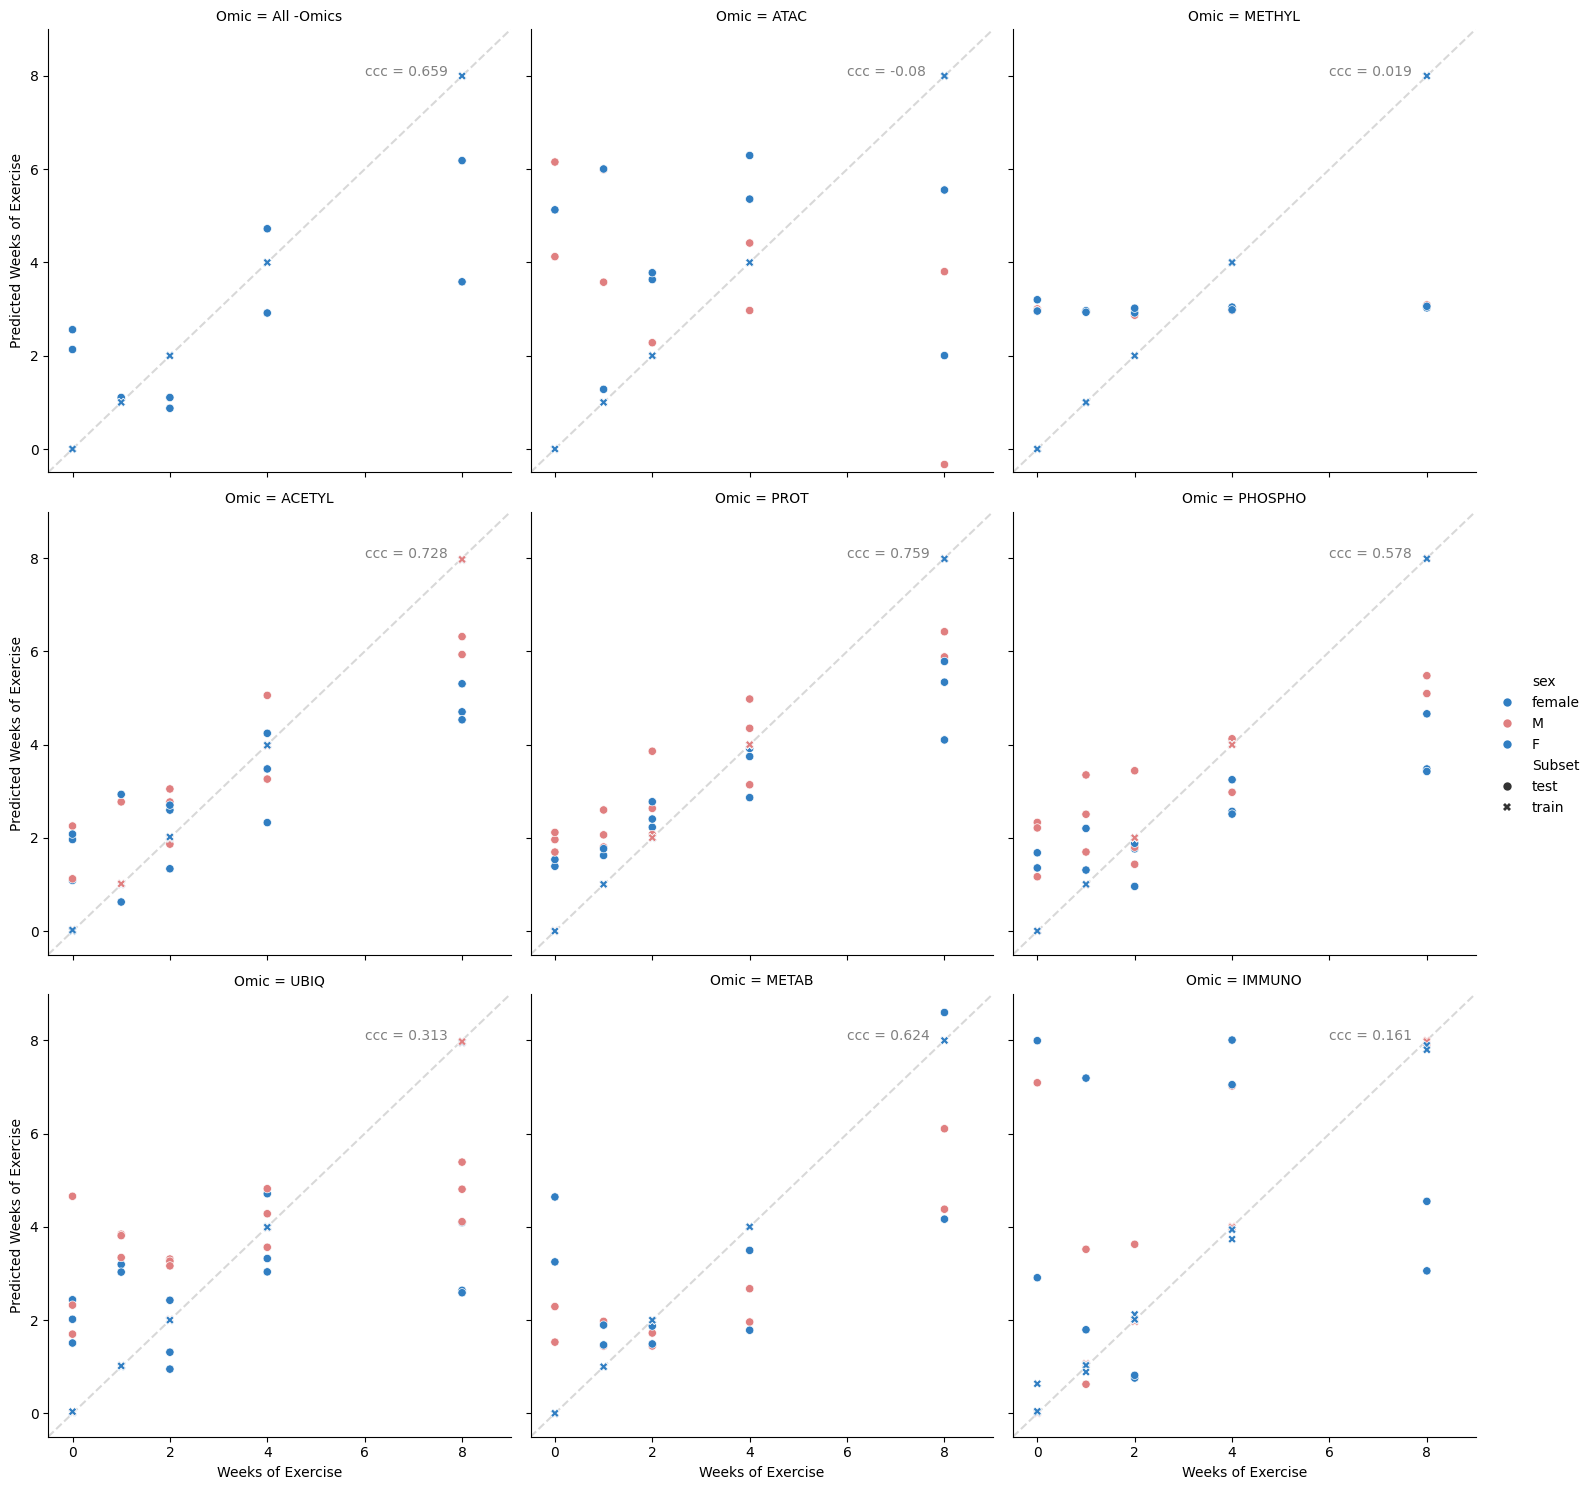

In [13]:
g = sns.relplot(data = result_df, x = 'Weeks of Exercise', y = 'Predicted Weeks of Exercise', hue = 'sex', style = 'Subset',
              col = 'Omic', palette = color_dict, col_wrap=3)
key_num=0
for ax in g.axes_dict.values():
    ax.axline((0, 0), slope=1, color = 'grey', alpha = .3, linestyle='--', zorder=0)
    ax.text(6, 8, f'ccc = {round(result_df[result_df.Omic == list(g.axes_dict.keys())[key_num]].ccc[0], 3)}', c = 'grey')
    key_num += 1
g.set(xlim=(-.5, 9), ylim=(-.5, 9))
plt.savefig(f'figures_final/supp_fig_4.png')
plt.show()

# See if Genes that are Predictive in RNA are predictive when used for other OMICs

## ATAC

In [14]:
omic = 'ATAC'
adata = load_annotated_omic(f'omics_adata/rat_{omic}_meta.h5ad', omic)
adata

AnnData object with n_obs × n_vars = 400 × 1213087
    obs: 'X', 'viallabel', 'pid', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'group', 'sex', 'tissue', 'time', 'rank', 'nid', 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path'
    var: 'assay', 'assay_code', 'feature_ID', 'chrom', 'start', 'end', 'width', 'chipseeker_annotation', 'custom_annotation', 'distanceToTSS', 'relationship_to_gene', 'ensembl_gene', 'geneStart', 'geneEnd', 'geneLength', 'geneStrand', 'omic'
    uns: 'X_name'
    layers: 'counts'

In [ ]:
time_coeff = pd.read_csv('metadata_csvs/linear_regression_time_coeffs.csv')
# filter for tissues present in ATAC
time_coeff['feature'] = time_coeff.feature.str.split('_', expand = True)[0]
time_coeff = time_coeff[time_coeff.tissue.isin(adata.obs.tissue.unique())]
time_coeff = time_coeff.sort_values(by='abs_coeff', ascending=False).iloc[:100,:]
time_coeff.head(), time_coeff.shape

(           coeff  abs_coeff             feature  tissue  feature_num
 123543 -0.000009   0.000009  ENSRNOG00000013552     BAT       123543
 330245  0.000009   0.000009  ENSRNOG00000013552   LIVER       330245
 130547 -0.000007   0.000007  ENSRNOG00000033299     BAT       130547
 77876  -0.000007   0.000007  ENSRNOG00000016275  HIPPOC        77876
 130754  0.000006   0.000006  ENSRNOG00000034234     BAT       130754,
 (100, 5))

Filter for most relevant genomic regions

In [16]:
corr_adata = adata[:,adata.var.ensembl_gene.isin(time_coeff.feature.values)]
corr_adata = corr_adata[:,corr_adata.var.custom_annotation.isin(['Promoter (1-2kb)', 'Promoter (<=1kb)','Intron', 'Exon'])]
corr_adata

View of AnnData object with n_obs × n_vars = 400 × 1042
    obs: 'X', 'viallabel', 'pid', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'group', 'sex', 'tissue', 'time', 'rank', 'nid', 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path'
    var: 'assay', 'assay_code', 'feature_ID', 'chrom', 'start', 'end', 'width', 'chipseeker_annotation', 'custom_annotation', 'distanceToTSS', 'relationship_to_gene', 'ensembl_gene', 'geneStart', 'geneEnd', 'geneLength', 'geneStrand', 'omic'
    uns: 'X_name'
    layers: 'counts'

In [18]:
X, y, z = data_reshaper_omic(corr_adata, tiss_list = corr_adata.obs.tissue.unique(), omic='ATAC')
y = y.reset_index(drop=True)

np.random.seed(0)

train_filter = y.reset_index(drop=True)[['nid', 'time', 'sex']].groupby('nid',observed=False).agg(lambda x: x.value_counts().index[0])
train_nids = train_filter.groupby(['time', 'sex'],observed=False).apply(lambda x: x.sample(1+np.round(len(x)/3).astype('int')),include_groups=False).index.get_level_values(2).tolist()
ref_mask = [x in train_nids for x in y.nid]


X_train = X[ref_mask]
X_test = X[list(~np.array(ref_mask))]
y_train = y[ref_mask]
y_test = y[list(~np.array(ref_mask))]

# instantiate the model (using the default parameters)
model = sklearn.linear_model.Ridge(random_state=0)

# fit the model with data
model.fit(X_train, y_train.time)

y_pred = model.predict(X_test)
big_ccc = get_CCC(y_test.time.astype('int'), y_pred)
big_r2 = sklearn.metrics.r2_score(y_test.time.astype('int'), y_pred)

/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


BAT
HEART
HIPPOC
KIDNEY
LIVER
LUNG
SKM-GN
WAT


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:750: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['M0A', 'M8A', 'M8B', 'M8C', 'M8E']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [19]:
test_df = pd.DataFrame({'prediction' : y_pred,
                            'actual' : y_test.time,
                            'Sex': y_test.sex
                             })
test_df.index = y_test.nid
test_df['Subset'] = 'test'
train_df = pd.DataFrame({'prediction' : model.predict(X_train),
                            'actual' : y_train.time,
                            'Sex': y_train.sex
                             })
train_df.index = y_train.nid
train_df['Subset'] = 'train'

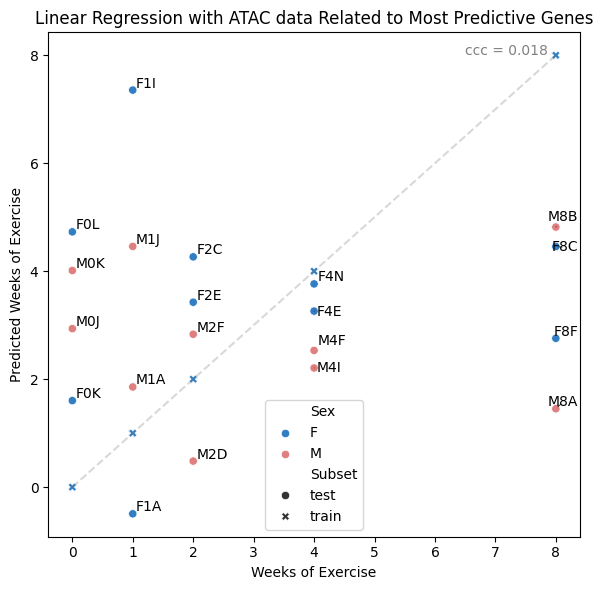

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(pd.concat([test_df, train_df]), x = 'actual', y = 'prediction', hue = 'Sex', style = 'Subset',
                   palette = color_dict)
plt.plot([0, 8], [0, 8], color = 'grey', alpha = .3, linestyle='--')
plt.text(6.5, 8, f'ccc = {round(big_ccc, 3)}', c = 'grey')
plt.xlabel('Weeks of Exercise')
plt.ylabel('Predicted Weeks of Exercise')
plt.title('Linear Regression with ATAC data Related to Most Predictive Genes')
from adjustText import adjust_text
texts=[]
for i,r in test_df.iterrows():
    texts.append(plt.text(x=r['actual'],y=r['prediction'],s=i))
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
plt.tight_layout()
plt.savefig(f'figures_final/fig_10a.png')
plt.show()

## PROT

In [21]:
omic = 'PROT'
adata = load_annotated_omic(f'omics_adata/rat_{omic}_meta.h5ad', omic)
adata

AnnData object with n_obs × n_vars = 416 × 3917
    obs: 'X', 'viallabel', 'pid', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'group', 'sex', 'tissue', 'time', 'rank', 'nid', 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path'
    var: 'feature_ID', 'entrez_gene', 'rgd_gene', 'gene_symbol', 'old_gene_symbol', 'ensembl_gene', 'relationship_to_gene', 'custom_annotation', 'kegg_id', 'omic'
    uns: 'X_name'
    layers: 'counts'

In [ ]:
time_coeff = pd.read_csv('metadata_csvs/linear_regression_time_coeffs.csv')
# filter for tissues present in PROT
time_coeff['feature'] = time_coeff.feature.str.split('_', expand = True)[0]
time_coeff = time_coeff[time_coeff.tissue.isin(adata.obs.tissue.unique())]
time_coeff = time_coeff.sort_values(by='abs_coeff', ascending=False).iloc[:1000,:]
time_coeff.head(), time_coeff.shape

(           coeff  abs_coeff             feature  tissue  feature_num
 330245  0.000009   0.000009  ENSRNOG00000013552   LIVER       330245
 1865    0.000006   0.000006  ENSRNOG00000003897  SKM-GN         1865
 344314 -0.000006   0.000006  ENSRNOG00000067602   LIVER       344314
 95317  -0.000006   0.000006  ENSRNOG00000003897     WAT        95317
 308984  0.000005   0.000005  ENSRNOG00000016983   HEART       308984,
 (1000, 5))

In [23]:
corr_adata = adata[:,adata.var.ensembl_gene.isin(time_coeff.feature.values)]
corr_adata

View of AnnData object with n_obs × n_vars = 416 × 250
    obs: 'X', 'viallabel', 'pid', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'group', 'sex', 'tissue', 'time', 'rank', 'nid', 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path'
    var: 'feature_ID', 'entrez_gene', 'rgd_gene', 'gene_symbol', 'old_gene_symbol', 'ensembl_gene', 'relationship_to_gene', 'custom_annotation', 'kegg_id', 'omic'
    uns: 'X_name'
    layers: 'counts'

In [24]:
X, y, z = data_reshaper_omic(corr_adata, tiss_list = corr_adata.obs.tissue.unique(), omic=omic)
y = y.reset_index(drop=True)

np.random.seed(0)

train_filter = y.reset_index(drop=True)[['nid', 'time', 'sex']].groupby('nid',observed=False).agg(lambda x: x.value_counts().index[0])
train_nids = train_filter.groupby(['time', 'sex'],observed=False).apply(lambda x: x.sample(1+np.round(len(x)/3).astype('int')),include_groups=False).index.get_level_values(2).tolist()
ref_mask = [x in train_nids for x in y.nid]


X_train = X[ref_mask]
X_test = X[list(~np.array(ref_mask))]
y_train = y[ref_mask]
y_test = y[list(~np.array(ref_mask))]

# instantiate the model (using the default parameters)
model = sklearn.linear_model.Ridge(random_state=0)

# fit the model with data
model.fit(X_train, y_train.time)

y_pred = model.predict(X_test)
big_ccc = get_CCC(y_test.time.astype('int'), y_pred)
big_r2 = sklearn.metrics.r2_score(y_test.time.astype('int'), y_pred)

/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


CORTEX
SKM-GN
HEART
KIDNEY
LIVER
LUNG
WAT


In [25]:
test_df = pd.DataFrame({'prediction' : y_pred,
                            'actual' : y_test.time,
                            'Sex': y_test.sex
                             })
test_df.index = y_test.nid
test_df['Subset'] = 'test'
train_df = pd.DataFrame({'prediction' : model.predict(X_train),
                            'actual' : y_train.time,
                            'Sex': y_train.sex
                             })
train_df.index = y_train.nid
train_df['Subset'] = 'train'

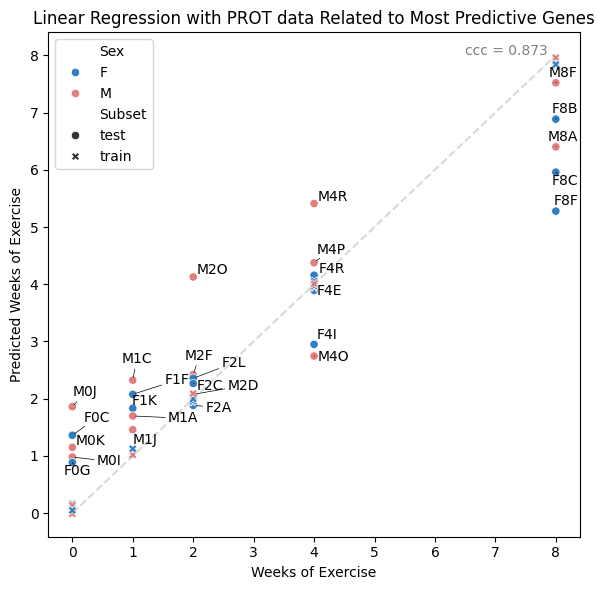

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(pd.concat([test_df, train_df]), x = 'actual', y = 'prediction', hue = 'Sex', style = 'Subset',
                   palette = color_dict)
plt.plot([0, 8], [0, 8], color = 'grey', alpha = .3, linestyle='--')
plt.text(6.5, 8, f'ccc = {round(big_ccc, 3)}', c = 'grey')
plt.xlabel('Weeks of Exercise')
plt.ylabel('Predicted Weeks of Exercise')
plt.title('Linear Regression with PROT data Related to Most Predictive Genes')
from adjustText import adjust_text
texts=[]
for i,r in test_df.iterrows():
    texts.append(plt.text(x=r['actual'],y=r['prediction'],s=i))
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
plt.tight_layout()
plt.savefig(f'figures_final/fig_10b.png')
plt.show()